In [6]:
import pandas as pd
import numpy as np

In [7]:
import xgboost as xgb


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import combinations
import statistics
import time
from datetime import datetime
import matplotlib.dates as mdates

from warnings import filterwarnings
filterwarnings('ignore')

In [9]:
import os
for dirname, _, filenames in os.walk('C:\\Users\\user\\kaggle_playground\\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sub = pd.read_csv('./data/sample_submission.csv')


In [11]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [6]:
# train and test reset row_id index
train.set_index('row_id', inplace=True)
test.set_index('row_id', inplace=True)

In [7]:
train.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [8]:
test.head()

,date,country,store,product
row_id,,,,
26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [9]:
# change date datatype to datatime 
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

In [10]:
#Add day of week Monday:0 Sunday:6
daysOfWeek = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
train['day_of_week'] = train['date'].dt.day_name().map(daysOfWeek)
test['day_of_week'] = test['date'].dt.day_name().map(daysOfWeek)


In [11]:
# weekend in days of week weekend are Saturday and Sunday yes 1 if no 0 
train['weekend'] = [ 1 if a in [4,5,6] else 0 for a in train['day_of_week']]
test['weekend'] = [ 1 if a in [4,5,6] else 0 for a in test['day_of_week']]

In [12]:
train

,date,country,store,product,num_sold,day_of_week,weekend
row_id,,,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,3,0
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,3,0
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,3,0
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,3,0
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,3,0
...,...,...,...,...,...,...,...
26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823,0,0
26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250,0,0
26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004,0,0


In [13]:
test = test.drop(['date'], axis=1)
train = train.drop(['date'], axis=1)

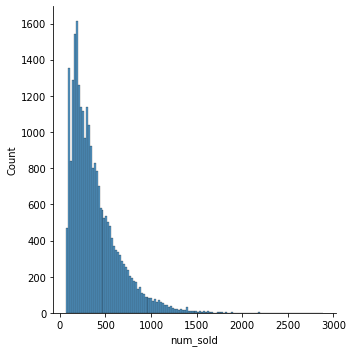

In [14]:
sns.displot(data= train, x='num_sold')

<AxesSubplot:xlabel='store', ylabel='count'>

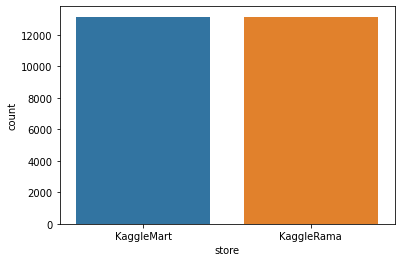

In [15]:
# countplot  for store
sns.countplot(data= train, x='store')


<AxesSubplot:xlabel='country', ylabel='count'>

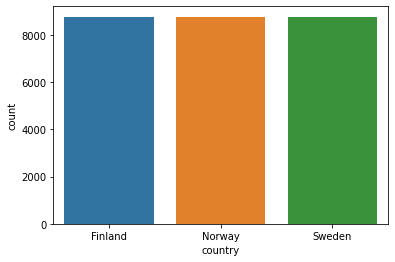

In [19]:
# countplot  for country
sns.countplot(data= train, x='country')

In [23]:
train.groupby('country')['num_sold'].mean()
# country with highest sales


country
Finland    305.832421
Norway     502.476158
Sweden     354.292151
Name: num_sold, dtype: float64

In [22]:
train.groupby('country')['num_sold'].max()

country
Finland    1895
Norway     2884
Sweden     2169
Name: num_sold, dtype: int64

In [24]:
print(train.columns)

Index(['row_id', 'country', 'store', 'product', 'num_sold', 'day_of_week',
       'weekend'],
      dtype='object')


In [25]:
print(test.columns)

Index(['row_id', 'country', 'store', 'product', 'day_of_week', 'weekend'], dtype='object')


In [26]:
# import label encoder
from sklearn.preprocessing import LabelEncoder


In [27]:
# converting categorical data to numerical data 
label = LabelEncoder()
train = train.apply(lambda x: label.fit_transform(x) if x.dtype == 'object' else x)





In [29]:
# test categorical data to numerical data
test = test.apply(lambda x: label.fit_transform(x) if x.dtype == 'object' else x)

In [31]:
test.head()

,row_id,country,store,product,day_of_week,weekend
0,26298,0,0,1,1,0
1,26299,0,0,0,1,0
2,26300,0,0,2,1,0
3,26301,0,1,1,1,0
4,26302,0,1,0,1,0


In [ ]:
# import standard scaler
from sklearn.preprocessing import StandardScaler


In [ ]:
def smape_loss(y_true, y_pred):
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

In [32]:
# preprocess the data 
preproc = StandardScaler()
train = preproc.fit_transform(train)
test = preproc.transform(test)

row_id
country
store
product
num_sold
day_of_week
weekend
